# Self-driving car Nanodegree - Term 1

## Project 3: **Advanced Lane Lines** 
***
In this project, We attempted to identify the lane boundaries in a video.

---
#### Importing packages

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle
import numpy as np
import glob
import os

---
#### Define directories and parameters

In [2]:
'''Directory'''
CAMERA_IMAGE_DIRECTORY = '../camera_cal/'
OUTPUT_DIRRECTORY = '../output_images/'
TEST_IMAGES_DIRECTORY = '../test_images/'

'''Define Parameters'''
KERNEL_SIZE = 3
OFFSET = 100
NX = 9
NY = 6
THRESHOLD_MIN = 0
THRESHOLD_MAX = 255
MAGNITUDE_THRESHOLD = (0, 255)
DIRECTION_THRESHOLD = (0, np.pi/2)
SATURATION_THRESHOLD = (170, 255)

#### Helper functions
---
##### Apply a distortion correction to raw images.

In [4]:
#Prepare obj poinrts
objp = np.zeros((NX * NY, 3), np.float32)
objp[:,:2] = np.mgrid[0:NX, 0:NY].T.reshape(-1,2)
obj_points = [] #3d points in real world space
img_points = [] #2d points in image points

images = glob.glob(CAMERA_IMAGE_DIRECTORY + 'calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    image_name=os.path.split(fname)[1]
    ret, corners = cv2.findChessboardCorners(img, (NX, NY), None)
    if ret == True:
        obj_points.append(objp)
        img_points.append(corners)
        cv2.drawChessboardCorners(img, (NX, NY), corners, ret)
        corners_write_name = OUTPUT_DIRRECTORY + 'corners/' +  'corners_found_'+ str(NX) + '_' + str(NY) + '_' + image_name
        cv2.imwrite(corners_write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

# Calcualte the undistortion matrix 
img_size = (img.shape[1],img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size, None, None)

In [3]:
def undistort_image(img):           
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted

In [5]:
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    image_name=os.path.split(fname)[1]
    undistort = undistort_image(img)                  
    undistort_write_name = OUTPUT_DIRRECTORY + 'undistort/' + 'undistort_' + image_name
    cv2.imwrite(undistort_write_name, undistort) 
    cv2.imshow('undistort', undistort)
    cv2.waitKey(500)
cv2.destroyAllWindows()

---
##### Use color transforms, gradients, etc., to create a thresholded binary image.

In [6]:
def grayscale(image, order = 'BGR'):
    if order == "BGR":
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif order == "RGB":
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = None
    return gray

def abs_sobel_thresh(gray_img, orient='x', thresh_min = 0, thresh_max = 255):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

def magnitude_threshold(gray_img, sobel_kernel = 3, mag_thresh = (0, 255)): 
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray_imgy, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(grad_mag)/255 
    grad_mag = (grad_mag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(grad_mag)
    binary_output[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1
    return binary_output

def direction_threshold(gray_img, sobel_kernel = 3, dir_thresh = (0, np.pi/2)):
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_grad_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(abs_grad_dir)
    binary_output[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1
    return binary_output 

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# Edit this function to create your own pipeline.
def pipeline(img, is_gray = 'No', saturation_threshold = (170, 255), sx_thresh = (20, 100), lightness_threshole = (40,255)):
    
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
     # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= saturation_threshold[0]) & (s_channel <= saturation_threshold[1])] = 1
    
    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= lightness_threshole[0]) & (l_channel <= lightness_threshole[1])] = 1
    
    channels = 255 * np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')        
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = 255 * np.dstack((binary,binary,binary)).astype('uint8')   
    
    return binary, channels

In [7]:
test_images = glob.glob(TEST_IMAGES_DIRECTORY + '*.jpg')

for idx, fname in enumerate(test_images):
    img = cv2.imread(fname)
    image_name = os.path.split(fname)[1]
    undistort = undistort_image(img)   
    binary_img, channel = pipeline(undistort, is_gray = 'No', saturation_threshold = SATURATION_THRESHOLD, sx_thresh=(20, 100))
    plt.imsave(OUTPUT_DIRRECTORY + 'threshold/' + 'binary_' + image_name, binary_img)
    plt.imsave(OUTPUT_DIRRECTORY + 'threshold/' + 'channel_' + image_name, binary_img)


---
##### Apply a perspective transform to rectify binary image ("birds-eye view").

In [17]:
def warp(image, corners, offset):
    img_size = (image.shape[1], image.shape[0])
    
    src = np.float32([corners[0], corners[NX - 1], corners[-1], corners[-NX]])
    
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                 [img_size[0]-offset, img_size[1]-offset], 
                                 [offset, img_size[1]-offset]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, img_size)
    return warped, M

for idx, fname in enumerate(test_images):
    img = cv2.imread(fname)
    image_name=os.path.split(fname)[1]
    undistort = undistort_image(img) 
    gray_img = grayscale(undistort, order = 'BGR')
    # need to get corners
    ret, corners = cv2.findChessboardCorners(gray_img, (NX, NY), None)
    if ret == True:
        warp_img, M = warp(undistort, corners, offset = OFFSET) 
        plt.imsave(OUTPUT_DIRRECTORY + 'perspective_transform/' + 'warp_' + image_name, warp_img)

[[[185 138  84]
  [186 139  85]
  [186 139  85]
  ..., 
  [178 130  72]
  [179 131  73]
  [180 132  74]]

 [[185 137  85]
  [186 138  86]
  [186 138  86]
  ..., 
  [178 130  72]
  [179 131  73]
  [180 132  74]]

 [[185 137  85]
  [185 137  85]
  [186 138  86]
  ..., 
  [177 131  73]
  [178 131  73]
  [177 131  73]]

 ..., 
 [[ 99  83  95]
  [ 99  83  95]
  [ 99  83  96]
  ..., 
  [ 93  97 118]
  [ 91  96 116]
  [ 90  94 114]]

 [[ 98  84  96]
  [ 98  84  96]
  [ 98  84  96]
  ..., 
  [ 90  95 116]
  [ 92  97 118]
  [ 90  95 116]]

 [[ 96  84  96]
  [ 96  84  96]
  [ 97  85  97]
  ..., 
  [ 91  94 115]
  [ 92  96 117]
  [ 91  95 116]]]
[[188 150 139 ...,  63  33  37]
 [148 137 122 ..., 109  76  29]
 [138 125 118 ..., 118 110  65]
 ..., 
 [120  92  85 ...,  74  90 122]
 [139 113  94 ...,  80 114 139]
 [181 136 121 ..., 116 136 181]]
False
None
[[[183 137  90]
  [182 136  89]
  [181 135  88]
  ..., 
  [ 78  89  93]
  [ 81  92  96]
  [ 80  92  96]]

 [[183 137  90]
  [183 137  90]
  [183 1

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

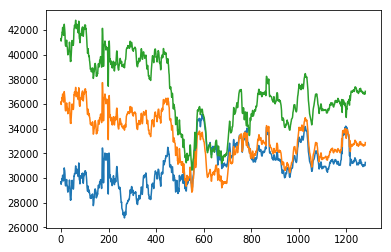

In [9]:

img = cv2.imread(TEST_IMAGES_DIRECTORY + 'straight_lines1.jpg')
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)